In [2]:
# Load libriaries.
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

# Instantiate objects.
scaler = MinMaxScaler()

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = 1.0
plt.rcParams['font.size'] = 6.0
plt.rcParams['axes.titlesize'] = 6.0

In [3]:
# Define moving-average function.
def moving_average(x, w):
    return np.convolve(x, np.ones(w), "same") / w
w = 672 # 1 week for moving average

# Load data and keep only first six months.
data = pd.read_csv("Zimmerman2018.csv", index_col=0)

# Visualize data summary.
data.describe()

,CO_ref,CO2_ref,SO2_ref,NO2_ref,O3_ref,Alphasense_CO-B41#1,Alphasense_SO2-B4#1,Alphasense_NO2-B43F#1,Alphasense_OX-B431#1,CO2#1,...,CO2#18,T#18,RH#18,Alphasense_CO-B41#19,Alphasense_SO2-B4#19,Alphasense_NO2-B43F#19,Alphasense_OX-B431#19,CO2#19,T#19,RH#19
count,14630.000000,13830.000000,2234.000000,9429.000000,14194.000000,6574.000000,6574.000000,6574.000000,6574.000000,6574.000000,...,9219.000000,9219.000000,9219.000000,6570.000000,6570.000000,6570.000000,6570.000000,6570.000000,6570.000000,6570.000000
mean,263.118649,442.705800,1.031936,10.887076,22.100680,-185.588917,7.758719,12.703853,23.552130,769.501245,...,892.599772,16.693705,71.260951,-100.080652,6.142436,6.126899,26.699868,618.874086,21.112909,68.543435
std,237.577854,30.467453,1.143763,7.492827,11.515163,168.256504,7.201765,3.524194,5.830497,457.354590,...,590.472150,8.736281,12.981758,200.032452,8.352555,6.287330,11.482361,145.373696,7.863764,14.374059
min,39.511100,403.020000,0.001100,0.038420,0.004304,-1996.370000,-38.672700,1.650790,5.576270,1.555560,...,0.000000,-4.653330,31.868300,-2271.500000,-37.916700,-17.132100,-7.129030,0.163934,-7.710000,31.720300
25%,156.679750,425.462000,0.306059,5.604380,14.150550,-186.308500,4.387242,10.408000,19.485200,462.862250,...,529.192000,9.700000,61.719000,-159.358000,1.083685,2.656473,17.740875,532.911000,17.400000,57.164650
50%,190.287000,432.782500,0.673145,8.729700,21.301700,-124.200000,8.939960,12.527300,23.220200,615.553000,...,720.000000,17.300000,72.200000,-100.500000,5.474130,6.157890,25.008350,594.884000,22.236450,69.800000
75%,264.302500,447.236750,1.266405,13.683400,28.902025,-100.436000,12.290750,14.655575,27.230525,947.830750,...,1125.420000,23.409100,82.043750,-30.456950,10.283000,10.000000,34.106475,705.833500,26.210375,80.299525
max,3234.940000,672.386000,8.270540,44.994100,80.614900,-20.836400,23.961500,29.491500,51.000000,2001.000000,...,2001.000000,35.724600,94.850000,564.964000,34.000000,32.092600,74.000000,1447.500000,37.272200,96.200000


In [4]:
# Stratify data.
data_red = data[(data.index >= "2016-10-10 00:00:00")].dropna(axis=1, how="any", thresh=0.66*sum(data.index >= "2016-10-10 00:00:00"))
t_s = (pd.to_datetime(data_red.index)-pd.to_datetime(data_red.index[0])).values.astype("timedelta64[m]") # time in minutes
data_red.describe()

,CO_ref,CO2_ref,NO2_ref,O3_ref,Alphasense_CO-B41#4,Alphasense_SO2-B4#4,Alphasense_NO2-B43F#4,Alphasense_OX-B431#4,CO2#4,T#4,...,CO2#16,T#16,RH#16,Alphasense_CO-B41#17,Alphasense_SO2-B4#17,Alphasense_NO2-B43F#17,Alphasense_OX-B431#17,CO2#17,T#17,RH#17
count,10020.000000,10351.000000,9333.000000,9417.000000,10055.000000,10055.000000,10055.000000,10055.000000,10055.000000,10055.000000,...,7894.000000,7894.000000,7894.000000,7698.000000,7698.000000,7698.00000,7698.000000,7698.000000,7698.000000,7698.000000
mean,275.193281,442.246188,10.969947,21.361927,-201.604001,6.184139,12.543444,22.459843,469.818142,6.015690,...,547.683091,6.706984,65.249933,-160.667201,12.632805,9.78186,22.077238,463.238893,6.739780,71.297183
std,242.184368,31.547392,7.485200,9.567744,155.832491,8.463350,3.719455,6.205154,155.642378,7.416733,...,190.346266,7.551328,2.642663,113.951768,8.083833,3.44502,5.782194,144.277773,7.576898,10.577500
min,76.933300,403.603000,0.038420,0.004304,-1827.400000,-66.236100,-4.000000,3.370370,0.000000,-15.382100,...,0.000000,-14.095800,57.047700,-1220.770000,-26.850000,-2.58621,6.543860,0.000000,-14.665000,44.096700
25%,162.144500,425.745000,5.691300,15.228700,-209.627500,3.205300,10.194200,18.074100,424.618000,0.985365,...,445.741000,1.560000,63.718200,-172.936000,8.643633,7.60000,18.049200,427.641750,1.600000,63.496875
50%,194.040500,432.274000,8.811800,21.319100,-146.983000,7.433330,12.472700,22.214300,463.750000,5.094640,...,508.915500,5.812200,65.400000,-121.800000,14.200000,9.71667,21.605200,452.475000,5.838395,70.852200
75%,270.376750,442.687000,13.763700,27.685600,-120.991500,11.500000,14.914550,26.536100,510.339000,10.449050,...,605.257750,11.006450,67.100000,-98.883300,18.309100,11.86670,25.583300,488.677250,11.227075,79.791675
max,3003.950000,672.386000,44.994100,56.025400,-59.200000,23.781800,28.481500,47.234000,2001.000000,28.984900,...,2001.000000,28.382500,72.284500,-51.566700,33.816700,25.85250,48.900000,2001.000000,28.269100,95.513300


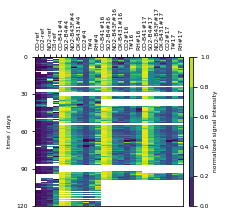

In [5]:
# Draw overview plot.
references = ['CO-ref', 'CO2-ref', 'NO2-ref', 'O3-ref']
labels = references + [column[-1] for column in [column.split("_", 1) for column in data_red.columns[4:]]]

fig = plt.figure(figsize=(2.95, 2.95))
axmatrix = fig.add_axes([0.0,0.0,0.70,0.70])
im = axmatrix.matshow(scaler.fit_transform(data_red.values), aspect='auto', origin='upper', cmap=plt.cm.viridis)
axmatrix.tick_params(axis="x", bottom=False, top=True, labelbottom=False, labeltop=True)
plt.xticks((np.arange(0, len(labels))), (labels), rotation=90)
plt.yticks(np.linspace(0, data_red.shape[0], 5), np.round(15*np.linspace(0, data_red.shape[0], 5)/(60*24), 0).astype("int"))
plt.ylabel('time / days')

bounds = np.linspace(0, 1, 6)
axcolor = fig.add_axes([0.725,0.0,0.02,0.70])
cbar = plt.colorbar(im, cax=axcolor, boundaries=bounds)
cbar.set_label('normalized signal intensity', rotation=90, fontsize=6)
cbar.ax.tick_params(labelsize=6) 

plt.savefig('./figures/time_traces',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

# 2 Weeks of Calibration

In [6]:
# Slice data into training session and validation session.
data_train = data_red[(data_red.index < "2016-10-24 00:00:00")]
data_train.fillna(value=data_train.mean(axis=0), axis=0, inplace=True)
data_val = data_red[(data_red.index >= "2016-10-24 00:00:00")]
data_val.fillna(value=data_val.mean(axis=0), axis=0, inplace=True)

/Users/gtancev/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


## Device #4

In [7]:
# Select traces.
references_1 = ['CO_ref', 'NO2_ref', 'O3_ref']
references_1_TRH = ['CO_ref', 'NO2_ref', 'O3_ref', 'T#4', 'RH#4']
sensors_1 = ['Alphasense_CO-B41#4', 'Alphasense_NO2-B43F#4', 'Alphasense_OX-B431#4']

# Create training sets.
sensors_1_train = data_train[sensors_1]
references_1_train = data_train[references_1]
references_1_TRH_train = data_train[references_1_TRH]

# Create validation sets.
sensors_1_val = data_val[sensors_1]
references_1_val = data_val[references_1]
references_1_TRH_val = data_val[references_1_TRH]

# Scaling data.
sensor_training_1 = scaler.fit_transform(sensors_1_train.values)
sensor_validation_1 = scaler.transform(sensors_1_val.values)
references_training_1 = scaler.fit_transform(references_1_train.values)
references_validation_1 = scaler.transform(references_1_val.values)

### Sensor Data

In [7]:
# Set amount of contamination.
contamination = 0.01

# Fit detectors.
EE = EllipticEnvelope(contamination=contamination, random_state=0).fit(sensor_training_1)
LOF = LocalOutlierFactor(n_neighbors=200, p=2, contamination=contamination, novelty=True, n_jobs=-1).fit(sensor_training_1)
OCSVM = OneClassSVM(kernel="rbf", gamma="auto", nu=contamination).fit(sensor_training_1)
IF = IsolationForest(n_estimators=100, bootstrap=True, contamination=contamination, random_state=0, n_jobs=-1).fit(sensor_training_1)

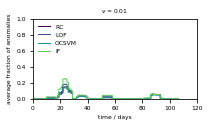

In [9]:
# Fraction of outliers.
fig = plt.figure(figsize=(2.95,0.5*2.95))
ax = fig.add_subplot(111)
plt.title(r"$\nu$ = "+str(contamination))
ax.plot(np.round(15*np.linspace(0, sensors_1_val.shape[0], sensors_1_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((EE.predict(sensor_validation_1)-1)/-2, w), color=plt.cm.viridis(0.0), label="RC")
ax.plot(np.round(15*np.linspace(0, sensors_1_val.shape[0], sensors_1_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((LOF.predict(sensor_validation_1)-1)/-2, w), color=plt.cm.viridis(0.25), label="LOF")
ax.plot(np.round(15*np.linspace(0, sensors_1_val.shape[0], sensors_1_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((OCSVM.predict(sensor_validation_1)-1)/-2, w), color=plt.cm.viridis(0.50), label="OCSVM")
ax.plot(np.round(15*np.linspace(0, sensors_1_val.shape[0], sensors_1_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((IF.predict(sensor_validation_1)-1)/-2, w), color=plt.cm.viridis(0.75), label="IF")
ax.set_xlim((0, 120))
ax.set_ylim((0, 1))
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_xlabel('time / days')
ax.set_ylabel('average fraction of anomalies')
ax.legend(frameon=False, loc=2)
plt.savefig('./figures/device_1/2_weeks/sensors_nu_001_fraction',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

In [10]:
# Set amount of contamination.
contamination = 0.05

# Fit detectors.
EE = EllipticEnvelope(contamination=contamination, random_state=0).fit(sensor_training_1)
LOF = LocalOutlierFactor(n_neighbors=200, p=2, contamination=contamination, novelty=True, n_jobs=-1).fit(sensor_training_1)
OCSVM = OneClassSVM(kernel="rbf", gamma="auto", nu=contamination).fit(sensor_training_1)
IF = IsolationForest(n_estimators=100, bootstrap=True, contamination=contamination, random_state=0, n_jobs=-1).fit(sensor_training_1)

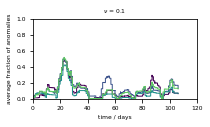

In [15]:
# Fraction of outliers.
fig = plt.figure(figsize=(2.95,0.5*2.95))
ax = fig.add_subplot(111)
plt.title(r"$\nu$ = "+str(contamination))
ax.plot(np.round(15*np.linspace(0, sensors_1_val.shape[0], sensors_1_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((EE.predict(sensor_validation_1)-1)/-2, w), color=plt.cm.viridis(0.0), label="RC")
ax.plot(np.round(15*np.linspace(0, sensors_1_val.shape[0], sensors_1_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((LOF.predict(sensor_validation_1)-1)/-2, w), color=plt.cm.viridis(0.25), label="LOF")
ax.plot(np.round(15*np.linspace(0, sensors_1_val.shape[0], sensors_1_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((OCSVM.predict(sensor_validation_1)-1)/-2, w), color=plt.cm.viridis(0.50), label="OCSVM")
ax.plot(np.round(15*np.linspace(0, sensors_1_val.shape[0], sensors_1_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((IF.predict(sensor_validation_1)-1)/-2, w), color=plt.cm.viridis(0.75), label="IF")
ax.set_xlim((0, 120))
ax.set_ylim((0, 1))
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_xlabel('time / days')
ax.set_ylabel('average fraction of anomalies')
#ax.legend(frameon=False, loc=2)
plt.savefig('./figures/device_1/2_weeks/sensors_nu_005_fraction',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

In [13]:
# Set amount of contamination.
contamination = 0.10

# Fit detectors.
EE = EllipticEnvelope(contamination=contamination, random_state=0).fit(sensor_training_1)
LOF = LocalOutlierFactor(n_neighbors=200, p=2, contamination=contamination, novelty=True, n_jobs=-1).fit(sensor_training_1)
OCSVM = OneClassSVM(kernel="rbf", gamma="auto", nu=contamination).fit(sensor_training_1)
IF = IsolationForest(n_estimators=100, bootstrap=True, contamination=contamination, random_state=0, n_jobs=-1).fit(sensor_training_1)

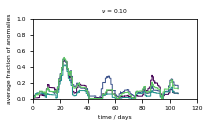

In [16]:
# Fraction of outliers.
fig = plt.figure(figsize=(2.95,0.5*2.95))
ax = fig.add_subplot(111)
plt.title(r"$\nu$ = 0.10")
ax.plot(np.round(15*np.linspace(0, sensors_1_val.shape[0], sensors_1_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((EE.predict(sensor_validation_1)-1)/-2, w), color=plt.cm.viridis(0.0), label="RC")
ax.plot(np.round(15*np.linspace(0, sensors_1_val.shape[0], sensors_1_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((LOF.predict(sensor_validation_1)-1)/-2, w), color=plt.cm.viridis(0.25), label="LOF")
ax.plot(np.round(15*np.linspace(0, sensors_1_val.shape[0], sensors_1_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((OCSVM.predict(sensor_validation_1)-1)/-2, w), color=plt.cm.viridis(0.50), label="OCSVM")
ax.plot(np.round(15*np.linspace(0, sensors_1_val.shape[0], sensors_1_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((IF.predict(sensor_validation_1)-1)/-2, w), color=plt.cm.viridis(0.75), label="IF")
ax.set_xlim((0, 120))
ax.set_ylim((0, 1))
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_xlabel('time / days')
ax.set_ylabel('average fraction of anomalies')
# ax.legend(frameon=False, loc=2)
plt.savefig('./figures/device_1/2_weeks/sensors_nu_010_fraction',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

### Reference Data

In [17]:
# Set amount of contamination.
contamination = 0.01

# Fit detectors.
EE = EllipticEnvelope(contamination=contamination, random_state=0).fit(references_training_1)
LOF = LocalOutlierFactor(n_neighbors=200, p=2, contamination=contamination, novelty=True, n_jobs=-1).fit(references_training_1)
OCSVM = OneClassSVM(kernel="rbf", gamma="auto", nu=contamination).fit(references_training_1)
IF = IsolationForest(n_estimators=100, bootstrap=True, contamination=contamination, random_state=0, n_jobs=-1).fit(references_training_1)

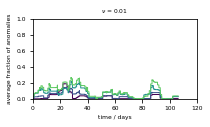

In [18]:
# Fraction of outliers.
fig = plt.figure(figsize=(2.95,0.5*2.95))
ax = fig.add_subplot(111)
plt.title(r"$\nu$ = "+str(contamination))
ax.plot(np.round(15*np.linspace(0, sensors_1_val.shape[0], sensors_1_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((EE.predict(references_validation_1)-1)/-2, w), color=plt.cm.viridis(0.0), label="RC")
ax.plot(np.round(15*np.linspace(0, sensors_1_val.shape[0], sensors_1_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((LOF.predict(references_validation_1)-1)/-2, w), color=plt.cm.viridis(0.25), label="LOF")
ax.plot(np.round(15*np.linspace(0, sensors_1_val.shape[0], sensors_1_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((OCSVM.predict(references_validation_1)-1)/-2, w), color=plt.cm.viridis(0.50), label="OCSVM")
ax.plot(np.round(15*np.linspace(0, sensors_1_val.shape[0], sensors_1_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((IF.predict(references_validation_1)-1)/-2, w), color=plt.cm.viridis(0.75), label="IF")
ax.set_xlim((0, 120))
ax.set_ylim((0, 1))
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_xlabel('time / days')
ax.set_ylabel('average fraction of anomalies')
# ax.legend(frameon=False, loc=2)
plt.savefig('./figures/device_1/2_weeks/references_nu_001_fraction',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

In [19]:
# Set amount of contamination.
contamination = 0.05

# Fit detectors.
EE = EllipticEnvelope(contamination=contamination, random_state=0).fit(references_training_1)
LOF = LocalOutlierFactor(n_neighbors=200, p=2, contamination=contamination, novelty=True, n_jobs=-1).fit(references_training_1)
OCSVM = OneClassSVM(kernel="rbf", gamma="auto", nu=contamination).fit(references_training_1)
IF = IsolationForest(n_estimators=100, bootstrap=True, contamination=contamination, random_state=0, n_jobs=-1).fit(references_training_1)

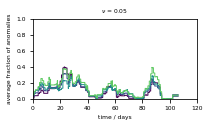

In [20]:
# Fraction of outliers.
fig = plt.figure(figsize=(2.95,0.5*2.95))
ax = fig.add_subplot(111)
plt.title(r"$\nu$ = "+str(contamination))
ax.plot(np.round(15*np.linspace(0, sensors_1_val.shape[0], sensors_1_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((EE.predict(references_validation_1)-1)/-2, w), color=plt.cm.viridis(0.0), label="RC")
ax.plot(np.round(15*np.linspace(0, sensors_1_val.shape[0], sensors_1_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((LOF.predict(references_validation_1)-1)/-2, w), color=plt.cm.viridis(0.25), label="LOF")
ax.plot(np.round(15*np.linspace(0, sensors_1_val.shape[0], sensors_1_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((OCSVM.predict(references_validation_1)-1)/-2, w), color=plt.cm.viridis(0.50), label="OCSVM")
ax.plot(np.round(15*np.linspace(0, sensors_1_val.shape[0], sensors_1_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((IF.predict(references_validation_1)-1)/-2, w), color=plt.cm.viridis(0.75), label="IF")
ax.set_xlim((0, 120))
ax.set_ylim((0, 1))
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_xlabel('time / days')
ax.set_ylabel('average fraction of anomalies')
# ax.legend(frameon=False, loc=2)
plt.savefig('./figures/device_1/2_weeks/references_nu_005_fraction',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

In [8]:
# Set amount of contamination.
contamination = 0.10

# Fit detectors.
EE = EllipticEnvelope(contamination=contamination, random_state=0).fit(references_training_1)
LOF = LocalOutlierFactor(n_neighbors=200, p=2, contamination=contamination, novelty=True, n_jobs=-1).fit(references_training_1)
OCSVM = OneClassSVM(kernel="rbf", gamma="auto", nu=contamination).fit(references_training_1)
IF = IsolationForest(n_estimators=100, bootstrap=True, contamination=contamination, random_state=0, n_jobs=-1).fit(references_training_1)

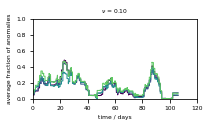

In [22]:
# Fraction of outliers.
fig = plt.figure(figsize=(2.95,0.5*2.95))
ax = fig.add_subplot(111)
plt.title(r"$\nu$ = 0.10")
ax.plot(np.round(15*np.linspace(0, sensors_1_val.shape[0], sensors_1_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((EE.predict(references_validation_1)-1)/-2, w), color=plt.cm.viridis(0.0), label="RC")
ax.plot(np.round(15*np.linspace(0, sensors_1_val.shape[0], sensors_1_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((LOF.predict(references_validation_1)-1)/-2, w), color=plt.cm.viridis(0.25), label="LOF")
ax.plot(np.round(15*np.linspace(0, sensors_1_val.shape[0], sensors_1_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((OCSVM.predict(references_validation_1)-1)/-2, w), color=plt.cm.viridis(0.50), label="OCSVM")
ax.plot(np.round(15*np.linspace(0, sensors_1_val.shape[0], sensors_1_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((IF.predict(references_validation_1)-1)/-2, w), color=plt.cm.viridis(0.75), label="IF")
ax.set_xlim((0, 120))
ax.set_ylim((0, 1))
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_xlabel('time / days')
ax.set_ylabel('average fraction of anomalies')
# ax.legend(frameon=False, loc=2)
plt.savefig('./figures/device_1/2_weeks/references_nu_010_fraction',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

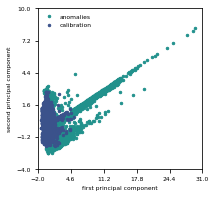

In [78]:
X_t = data_train[references_1].values[((LOF.predict(references_training_1)-1)/-2)==0, :] # regular calibration data
X_v = data_val[references_1].values[((LOF.predict(references_validation_1)-1)/-2)==1, :] # anomalous monitoring data

# np.quantile(X_v[:, 0], q=[0.01,0.05,0.25,0.5,0.75,0.95,0.99])
# np.quantile(X_t[:, 0], q=[0.01,0.05,0.25,0.5,0.75,0.95,0.99])

dim_red = PCA(n_components=2, whiten=True)
Y_t = dim_red.fit_transform(X_t)
Y_v = dim_red.transform(X_v)

fig = plt.figure(figsize=(2.95,2.95))
ax = fig.add_subplot(111)
ax.scatter(Y_v[:, 0], Y_v[:, 1], color=plt.cm.viridis(0.50), s=6, edgecolor=plt.cm.viridis(0.50), alpha=1.0, label="anomalies")
ax.scatter(Y_t[:, 0], Y_t[:, 1], color=plt.cm.viridis(0.25), s=6, edgecolor=plt.cm.viridis(0.25), alpha=1.0, label="calibration")
plt.xlim(-2.0, 31)
plt.ylim(-4.0, 10)
plt.xticks(np.linspace(-2.0, 31, 6))
plt.yticks(np.linspace(-4, 10, 6))
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.legend(frameon=False, loc=2)
plt.savefig('./figures/references_signal_distributions_PCA',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

## Device #16

In [23]:
# Select traces.
sensors_2 = ['Alphasense_CO-B41#16', 'Alphasense_NO2-B43F#16', 'Alphasense_OX-B431#16']

# Create training sets.
sensors_2_train = data_train[sensors_2]

# Create validation sets.
sensors_2_val = data_val[sensors_2]

# Scaling data.
sensor_training_2 = scaler.fit_transform(sensors_2_train.values)
sensor_validation_2 = scaler.transform(sensors_2_val.values)

In [24]:
# Set amount of contamination.
contamination = 0.01

# Fit detectors.
EE = EllipticEnvelope(contamination=contamination, random_state=0).fit(sensor_training_2)
LOF = LocalOutlierFactor(n_neighbors=200, p=2, contamination=contamination, novelty=True, n_jobs=-1).fit(sensor_training_2)
OCSVM = OneClassSVM(kernel="rbf", gamma="auto", nu=contamination).fit(sensor_training_2)
IF = IsolationForest(n_estimators=100, bootstrap=True, contamination=contamination, random_state=0, n_jobs=-1).fit(sensor_training_2)

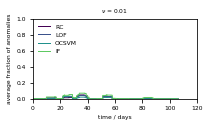

In [25]:
# Fraction of outliers.
fig = plt.figure(figsize=(2.95,0.5*2.95))
ax = fig.add_subplot(111)
plt.title(r"$\nu$ = "+str(contamination))
ax.plot(np.round(15*np.linspace(0, sensors_2_val.shape[0], sensors_2_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((EE.predict(sensor_validation_2)-1)/-2, w), color=plt.cm.viridis(0.0), label="RC")
ax.plot(np.round(15*np.linspace(0, sensors_2_val.shape[0], sensors_2_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((LOF.predict(sensor_validation_2)-1)/-2, w), color=plt.cm.viridis(0.25), label="LOF")
ax.plot(np.round(15*np.linspace(0, sensors_2_val.shape[0], sensors_2_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((OCSVM.predict(sensor_validation_2)-1)/-2, w), color=plt.cm.viridis(0.50), label="OCSVM")
ax.plot(np.round(15*np.linspace(0, sensors_2_val.shape[0], sensors_2_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((IF.predict(sensor_validation_2)-1)/-2, w), color=plt.cm.viridis(0.75), label="IF")
ax.set_xlim((0, 120))
ax.set_ylim((0, 1))
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_xlabel('time / days')
ax.set_ylabel('average fraction of anomalies')
ax.legend(frameon=False, loc=2)
plt.savefig('./figures/device_2/2_weeks/sensors_nu_001_fraction',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

In [27]:
# Set amount of contamination.
contamination = 0.05

# Fit detectors.
EE = EllipticEnvelope(contamination=contamination, random_state=0).fit(sensor_training_2)
LOF = LocalOutlierFactor(n_neighbors=200, p=2, contamination=contamination, novelty=True, n_jobs=-1).fit(sensor_training_2)
OCSVM = OneClassSVM(kernel="rbf", gamma="auto", nu=contamination).fit(sensor_training_2)
IF = IsolationForest(n_estimators=100, bootstrap=True, contamination=contamination, random_state=0, n_jobs=-1).fit(sensor_training_2)

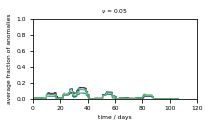

In [28]:
# Fraction of outliers.
fig = plt.figure(figsize=(2.95,0.5*2.95))
ax = fig.add_subplot(111)
plt.title(r"$\nu$ = "+str(contamination))
ax.plot(np.round(15*np.linspace(0, sensors_2_val.shape[0], sensors_2_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((EE.predict(sensor_validation_2)-1)/-2, w), color=plt.cm.viridis(0.0), label="RC")
ax.plot(np.round(15*np.linspace(0, sensors_2_val.shape[0], sensors_2_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((LOF.predict(sensor_validation_2)-1)/-2, w), color=plt.cm.viridis(0.25), label="LOF")
ax.plot(np.round(15*np.linspace(0, sensors_2_val.shape[0], sensors_2_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((OCSVM.predict(sensor_validation_2)-1)/-2, w), color=plt.cm.viridis(0.50), label="OCSVM")
ax.plot(np.round(15*np.linspace(0, sensors_2_val.shape[0], sensors_2_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((IF.predict(sensor_validation_2)-1)/-2, w), color=plt.cm.viridis(0.75), label="IF")
ax.set_xlim((0, 120))
ax.set_ylim((0, 1))
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_xlabel('time / days')
ax.set_ylabel('average fraction of anomalies')
# ax.legend(frameon=False, loc=2)
plt.savefig('./figures/device_2/2_weeks/sensors_nu_005_fraction',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

In [29]:
# Set amount of contamination.
contamination = 0.10

# Fit detectors.
EE = EllipticEnvelope(contamination=contamination, random_state=0).fit(sensor_training_2)
LOF = LocalOutlierFactor(n_neighbors=200, p=2, contamination=contamination, novelty=True, n_jobs=-1).fit(sensor_training_2)
OCSVM = OneClassSVM(kernel="rbf", gamma="auto", nu=contamination).fit(sensor_training_2)
IF = IsolationForest(n_estimators=100, bootstrap=True, contamination=contamination, random_state=0, n_jobs=-1).fit(sensor_training_2)

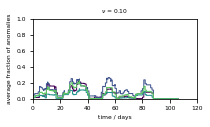

In [30]:
# Fraction of outliers.
fig = plt.figure(figsize=(2.95,0.5*2.95))
ax = fig.add_subplot(111)
plt.title(r"$\nu$ = 0.10")
ax.plot(np.round(15*np.linspace(0, sensors_2_val.shape[0], sensors_2_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((EE.predict(sensor_validation_2)-1)/-2, w), color=plt.cm.viridis(0.0), label="RC")
ax.plot(np.round(15*np.linspace(0, sensors_2_val.shape[0], sensors_2_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((LOF.predict(sensor_validation_2)-1)/-2, w), color=plt.cm.viridis(0.25), label="LOF")
ax.plot(np.round(15*np.linspace(0, sensors_2_val.shape[0], sensors_2_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((OCSVM.predict(sensor_validation_2)-1)/-2, w), color=plt.cm.viridis(0.50), label="OCSVM")
ax.plot(np.round(15*np.linspace(0, sensors_2_val.shape[0], sensors_2_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((IF.predict(sensor_validation_2)-1)/-2, w), color=plt.cm.viridis(0.75), label="IF")
ax.set_xlim((0, 120))
ax.set_ylim((0, 1))
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_xlabel('time / days')
ax.set_ylabel('average fraction of anomalies')
# ax.legend(frameon=False, loc=2)
plt.savefig('./figures/device_2/2_weeks/sensors_nu_010_fraction',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

## Device #17

In [31]:
# Select traces.
sensors_3 = ['Alphasense_CO-B41#17', 'Alphasense_NO2-B43F#17', 'Alphasense_OX-B431#17']

# Create training sets.
sensors_3_train = data_train[sensors_3]

# Create validation sets.
sensors_3_val = data_val[sensors_3]

# Scaling data.
sensor_training_3 = scaler.fit_transform(sensors_3_train.values)
sensor_validation_3 = scaler.transform(sensors_3_val.values)

In [32]:
# Set amount of contamination.
contamination = 0.01

# Fit detectors.
EE = EllipticEnvelope(contamination=contamination, random_state=0).fit(sensor_training_3)
LOF = LocalOutlierFactor(n_neighbors=200, p=2, contamination=contamination, novelty=True, n_jobs=-1).fit(sensor_training_3)
OCSVM = OneClassSVM(kernel="rbf", gamma="auto", nu=contamination).fit(sensor_training_3)
IF = IsolationForest(n_estimators=100, bootstrap=True, contamination=contamination, random_state=0, n_jobs=-1).fit(sensor_training_3)

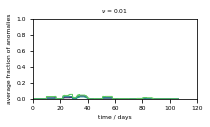

In [33]:
# Fraction of outliers.
fig = plt.figure(figsize=(2.95,0.5*2.95))
ax = fig.add_subplot(111)
plt.title(r"$\nu$ = "+str(contamination))
ax.plot(np.round(15*np.linspace(0, sensors_3_val.shape[0], sensors_3_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((EE.predict(sensor_validation_3)-1)/-2, w), color=plt.cm.viridis(0.0), label="RC")
ax.plot(np.round(15*np.linspace(0, sensors_3_val.shape[0], sensors_3_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((LOF.predict(sensor_validation_3)-1)/-2, w), color=plt.cm.viridis(0.25), label="LOF")
ax.plot(np.round(15*np.linspace(0, sensors_3_val.shape[0], sensors_3_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((OCSVM.predict(sensor_validation_3)-1)/-2, w), color=plt.cm.viridis(0.50), label="OCSVM")
ax.plot(np.round(15*np.linspace(0, sensors_3_val.shape[0], sensors_3_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((IF.predict(sensor_validation_3)-1)/-2, w), color=plt.cm.viridis(0.75), label="IF")
ax.set_xlim((0, 120))
ax.set_ylim((0, 1))
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_xlabel('time / days')
ax.set_ylabel('average fraction of anomalies')
# ax.legend(frameon=False, loc=2)
plt.savefig('./figures/device_3/2_weeks/sensors_nu_001_fraction',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

In [34]:
# Set amount of contamination.
contamination = 0.05

# Fit detectors.
EE = EllipticEnvelope(contamination=contamination, random_state=0).fit(sensor_training_3)
LOF = LocalOutlierFactor(n_neighbors=200, p=2, contamination=contamination, novelty=True, n_jobs=-1).fit(sensor_training_3)
OCSVM = OneClassSVM(kernel="rbf", gamma="auto", nu=contamination).fit(sensor_training_3)
IF = IsolationForest(n_estimators=100, bootstrap=True, contamination=contamination, random_state=0, n_jobs=-1).fit(sensor_training_3)

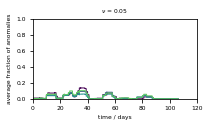

In [36]:
# Fraction of outliers.
fig = plt.figure(figsize=(2.95,0.5*2.95))
ax = fig.add_subplot(111)
plt.title(r"$\nu$ = "+str(contamination))
ax.plot(np.round(15*np.linspace(0, sensors_3_val.shape[0], sensors_3_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((EE.predict(sensor_validation_3)-1)/-2, w), color=plt.cm.viridis(0.0), label="RC")
ax.plot(np.round(15*np.linspace(0, sensors_3_val.shape[0], sensors_3_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((LOF.predict(sensor_validation_3)-1)/-2, w), color=plt.cm.viridis(0.25), label="LOF")
ax.plot(np.round(15*np.linspace(0, sensors_3_val.shape[0], sensors_3_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((OCSVM.predict(sensor_validation_3)-1)/-2, w), color=plt.cm.viridis(0.50), label="OCSVM")
ax.plot(np.round(15*np.linspace(0, sensors_3_val.shape[0], sensors_3_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((IF.predict(sensor_validation_3)-1)/-2, w), color=plt.cm.viridis(0.75), label="IF")
ax.set_xlim((0, 120))
ax.set_ylim((0, 1))
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_xlabel('time / days')
ax.set_ylabel('average fraction of anomalies')
# ax.legend(frameon=False, loc=2)
plt.savefig('./figures/device_3/2_weeks/sensors_nu_005_fraction',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

In [37]:
# Set amount of contamination.
contamination = 0.10

# Fit detectors.
EE = EllipticEnvelope(contamination=contamination, random_state=0).fit(sensor_training_3)
LOF = LocalOutlierFactor(n_neighbors=200, p=2, contamination=contamination, novelty=True, n_jobs=-1).fit(sensor_training_3)
OCSVM = OneClassSVM(kernel="rbf", gamma="auto", nu=contamination).fit(sensor_training_3)
IF = IsolationForest(n_estimators=100, bootstrap=True, contamination=contamination, random_state=0, n_jobs=-1).fit(sensor_training_3)

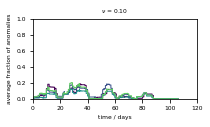

In [38]:
# Fraction of outliers.
fig = plt.figure(figsize=(2.95,0.5*2.95))
ax = fig.add_subplot(111)
plt.title(r"$\nu$ = 0.10")
ax.plot(np.round(15*np.linspace(0, sensors_3_val.shape[0], sensors_3_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((EE.predict(sensor_validation_3)-1)/-2, w), color=plt.cm.viridis(0.0), label="RC")
ax.plot(np.round(15*np.linspace(0, sensors_3_val.shape[0], sensors_3_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((LOF.predict(sensor_validation_3)-1)/-2, w), color=plt.cm.viridis(0.25), label="LOF")
ax.plot(np.round(15*np.linspace(0, sensors_3_val.shape[0], sensors_3_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((OCSVM.predict(sensor_validation_3)-1)/-2, w), color=plt.cm.viridis(0.50), label="OCSVM")
ax.plot(np.round(15*np.linspace(0, sensors_3_val.shape[0], sensors_3_val.shape[0])/(60*24), 0).astype("int"), 
        moving_average((IF.predict(sensor_validation_3)-1)/-2, w), color=plt.cm.viridis(0.75), label="IF")
ax.set_xlim((0, 120))
ax.set_ylim((0, 1))
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_xlabel('time / days')
ax.set_ylabel('average fraction of anomalies')
# ax.legend(frameon=False, loc=2)
plt.savefig('./figures/device_3/2_weeks/sensors_nu_010_fraction',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()